In [1]:
# This is the notebook for honours project analysis on galaxy cluster XLSSC 122
# This notebook will serve as sort of a journal of what is done on the project
# Proceeds chronologically with updated TODOs:

# Notebook part 6: correlation on true data
# First we load in the necessary modules:

# Standard libraries
import numpy as np;import scipy as sp;import matplotlib.pyplot as plt
import math;import warnings;import cv2
import matplotlib.ticker as tck

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.patches import Ellipse, Circle


# astro specific
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
#plt.style.use(astropy_mpl_style)
plt.style.use('default')
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import convolve, convolve_fft
from astropy.stats import kuiper

import FITS_tools
from operator import itemgetter


#plt.style.use('seaborn-deep')

# 3d plotting for mostly fun:
from mpl_toolkits import mplot3d
from skimage import io, transform 

# image reprojection:
from reproject import reproject_interp
import reproject
from scipy.spatial.distance import cdist

from scipy.stats import pearsonr

from matplotlib import rc

from matplotlib import rc

params = {"text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["cmr10"],
          "font.size": 20
         }
plt.rcParams.update(params)
plt.rcParams['axes.formatter.use_mathtext'] = True

import os
os.environ["PATH"]
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin/'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

# Set tick parameters using rcParams
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.major.width'] = 0.7
plt.rcParams['xtick.minor.width'] = 0.7
plt.rcParams['ytick.major.width'] = 0.7
plt.rcParams['ytick.minor.width'] = 0.7

plt.rcParams['font.weight'] = 'bold'

from matplotlib.colors import PowerNorm


In [2]:
# DATA:

# Now need to load in the data files for the fits image as well as the catalogues:

# fits:

fits_path ="/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/IVM_xlssuj0217-0345-f140w_drz_sci.fits"
xlssc_fits = fits.open(fits_path)

# extracted fits:

extract_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/xlssuj0217-0345-f140w_drz_seg_spec_extract.fits"
extract_fits = fits.open(extract_path)

# x-ray image:

xray_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/image400-3000_comb.fits"
xray_fits = fits.open(xray_path)

# smoothed x-ray image:

smooth_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/asmooth.fits"
smooth_fits = fits.open(smooth_path)

# catalogue files:

# shape of short file: 12 X 1374
# id ra dec (F105) kron ekron 0p8 e0p8 (F140) kron ekron 0p8 e0p8 fwhm (asec) 

cat_sh_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/xlssc122_F105_F140_short.cat"
cat_sh = np.loadtxt(cat_sh_path)

# shape of long file: 22 X 1301
# phot-id ra dec (f105) kron ekron 0p8 e0p8 (f140) kron ekron 0p8 e0p8 fwhm (asec) zz zlo zhi chi spec-id mcode snr em-code member1 member2

cat_lo_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/xlssc122_F105_F140_redshifts_short_v4_snr_em_member2_by_hand.cat"
cat_lo = np.loadtxt(cat_lo_path)

# data tble for members is the following shape 11 x 50:
#ID	RA (Deg)	DEC (Deg)	Mag (140W)	Colour	Z	Membership	quality	Age (Gyr)	Tau	Mass (log10(M/Ms))

data_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/extended_data_table.csv"
member_data = np.loadtxt(data_path, dtype='str',delimiter=',', skiprows=1).T

# syntax to sort a list of lists :
#sorted_by_140W = sorted(member_data.T, key=itemgetter(3))

# individual arrays of data for member galaxies:
nat_ID = np.array(member_data[0], dtype=float);  nat_RA = np.array(member_data[1], dtype=float);
nat_DEC = np.array(member_data[2], dtype=float); nat_mag = np.array(member_data[3], dtype=float);
nat_col = np.array(member_data[4], dtype=float); nat_z = np.array(member_data[5], dtype=float);
nat_notes = np.array(member_data[6], dtype=str); nat_quality = np.array(member_data[7], dtype=str)
nat_age =  np.array(member_data[8], dtype=float);nat_tau = np.array(member_data[9], dtype=float)
nat_mass =  np.array(member_data[10], dtype=float)

In [3]:
# projections:
xlssc_hdu = fits.open(fits_path)[0]
xlssc_wcs = WCS(xlssc_hdu.header)    
extract_hdu = fits.open(extract_path)[0]
extract_wcs = WCS(extract_hdu.header)
xray_hdu = fits.open(xray_path)[0]
xray_wcs = WCS(xray_hdu.header)
xray_smooth_hdu = fits.open(smooth_path)[0]
xray_smooth_wcs = WCS(xray_smooth_hdu.header)
xlssc_image = fits.getdata(fits_path, ext=0)
extract_image = fits.getdata(extract_path, ext=0)
xray_image = fits.getdata(xray_path, ext=0)
xray_smooth_image = fits.getdata(smooth_path, ext=0)


# ID	RA (Deg)	DEC (Deg)	Mag (105W)	Mag (140W)	Mag (140W).2	Colour.2	Colour	Z	Membership	quality	Age (Gyr)	Tau	
# Mass (log10(M/Ms))	Fluxes: int0	int1	int2	int3	Hanning	Gaussian	Exact	 manual

data_path = '/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/member_data_extended.csv'
mem_data = np.loadtxt(data_path, skiprows=1, delimiter=',', dtype='float', encoding='latin-1').T
mem_data_m26 = mem_data.T
mem_data_m26 = np.array([mem_data_m26[i] for i in range(len(mem_data_m26)) if ((np.isnan(mem_data_m26[i][13])==False))]).T

# potential member data:

#pot_masses = np.array([(pot_members[7][i] * m_red +b_red) for i in range(len(pot_members[0]))]) # log10(M)
pot_path = '/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/potential_members.csv'
pot_members = np.loadtxt(pot_path, skiprows=1, delimiter=',', dtype='float', encoding='latin-1').T

# fits:
mem_mass = mem_data[13]; mem_mag = mem_data[4]
nonzero_mass = [i for i in mem_mass if i != 0]
nonzero_mag = [mem_mag[i] for i in range(len(mem_mass)) if mem_mass[i] != 0 ]
m_mass,b_mass = np.polyfit(nonzero_mag,10**np.array(nonzero_mass),1)



# next sample with extrapolated masses:
mem_data_m37 = mem_data.T; masses = 10**mem_data[13]; mags = mem_data[4]

for i in range(len(masses)):
    if np.isnan(masses[i]) == True:
        mass = (m_mass*mags[i] +b_mass)
        if mass< 0:
            mass = 10**min(mem_data_m26[13])
        masses[i] = mass
              
mem_data_m37 = mem_data_m37.T; mem_data_m37[13] = np.log10(masses)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 57219.298958 from DATE-OBS.
Set MJD-END to 57220.498646 from DATE-END'. [astropy.wcs.wcs]


In [22]:
# now we want to create the faint red sample:
pot_path = '/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/potential_members.csv'

pot_members = np.loadtxt(pot_path, skiprows=1, delimiter=',', dtype='float', encoding='latin-1').T

m_red, b_red = np.polyfit(red_m26[4], red_m26[13],1)


pot_masses = np.array([(pot_members[7][i] * m_red +b_red) for i in range(len(pot_members[0]))]) # log10(M)
pot_path = '/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/potential_members.csv'
pot_members = np.loadtxt(pot_path, skiprows=1, delimiter=',', dtype='float', encoding='latin-1').T

faint_reds = np.array([pot_members.T[i] for i in range(len(pot_members.T)) if pot_members.T[i][25]==1]).T
                
faint_red_flux = faint_reds[23]; faint_red_mass = faint_reds[22]   
    
faint_reds_imp = [faint_reds[16], faint_reds[1], faint_reds[2], faint_reds[23], faint_reds[22]]    
    
    
all_red_mass = list(red_m26[13]) + list(faint_red_mass); all_red_flux = list(red_m26[21])+list(faint_red_flux)
all_red_RA = list(red_m26[1]) + list(faint_reds[1]); all_red_DEC = list(red_m26[2])+list(faint_reds[2])
all_red_ID = list(red_m26[0]) + list(faint_reds[16])

all_red_data = [all_red_ID, all_red_RA, all_red_DEC, all_red_mass, all_red_flux]


red_r, red_p =  sp.stats.pearsonr(10**np.array(all_red_mass), all_red_flux)

print(red_r,red_p)

redex_RA_kpc = [all_red_data[1][i]*degree_to_kpc for i in range(len(all_red_data[1]))]
redex_DEC_kpc = [all_red_data[2][i]*degree_to_kpc for i in range(len(all_red_data[2]))]

redex_pos_kpc = np.array([redex_RA_kpc - bcg_RA_kpc, redex_DEC_kpc - bcg_DEC_kpc])
redex_pos_kpc_T = np.array([redex_RA_kpc - bcg_RA_kpc, redex_DEC_kpc - bcg_DEC_kpc]).T

redex_rad_pos = np.array([np.sqrt((redex_pos_kpc[0][i]**2 + redex_pos_kpc[1][i]**2)) for i in range(len(redex_pos_kpc[1]))])


0.49107131901247897 5.772787382791583e-06


In [23]:
colours2=['#006483', '#84001c', '#012256','#696479', '#810053', '#ff5b65']


In [24]:
# First step is to generate a cumulative mass function for galaxies in the sample:

# we now want to find the radial cumulative number and mass functions for the galaxy cluster.
# procedure here is to take the RA and Dec of each object and convert it into a centred 
# radial position on the sky (may need some help from WCS).

# going to see if this works: 
# 1: subtract x-ray centre from member RA and DEC
# 2: use the cosmology calculator to find the kpc/" which we have previously
# 3: convert the differences from 1) into kpc distances using 2
# 4: plot the kpc positions on the xray frame in kpc pixel units from before
# 5: find R = sqrt(RA^2 + DEC^2)
# 6: find both the cumulative number and mass distributions as a function of R

# galaxy positions are: 

mem_RA = mem_data[1]; mem_DEC=mem_data[2]

mem_RA_m37=mem_data_m37[1]; mem_RA_m26=mem_data_m26[1]
mem_DEC_m37=mem_data_m37[2]; mem_DEC_m26=mem_data_m26[2]


# conversion factor is:

arcmin_to_kpc = 8.530 # kpc/"
degree_to_kpc = arcmin_to_kpc * 3600 # kpc/degree

# centre of xray image is:
xray_cdelt = xray_wcs.wcs.cdelt

xray_RA = 34.409; xray_DEC = -3.7431
# but we need the distance to the centre of the BCG i think?:

bcg_RA = mem_RA[0]; bcg_DEC = mem_DEC[0]

bcg_RA_kpc = bcg_RA * degree_to_kpc; bcg_DEC_kpc = bcg_DEC * degree_to_kpc;

# differences are then:

mem_RA_diff_m37 = [mem_RA[i] for i in range(len(mem_RA_m37))];mem_RA_diff_m26 = [mem_RA[i] for i in range(len(mem_RA_m26))];
mem_DEC_diff_m37 = [mem_DEC[i] for i in range(len(mem_DEC_m37))];mem_DEC_diff_m26 = [mem_DEC[i] for i in range(len(mem_DEC_m26))]

# in kpc:

mem_RA_kpc_m26 = [mem_RA_diff_m26[i]*degree_to_kpc for i in range(len(mem_RA_m26))]
mem_DEC_kpc_m37 = [mem_DEC_diff_m37[i]*degree_to_kpc for i in range(len(mem_RA_m37))]

mem_RA_kpc_m37 = [mem_RA_diff_m37[i]*degree_to_kpc for i in range(len(mem_RA_m37))]
mem_DEC_kpc_m26 = [mem_DEC_diff_m26[i]*degree_to_kpc for i in range(len(mem_RA_m26))]

kpc_pos_m26 = np.array([mem_RA_kpc_m26 - bcg_RA_kpc, mem_DEC_kpc_m26 - bcg_DEC_kpc])
kpc_pos_m37 = np.array([mem_RA_kpc_m37 - bcg_RA_kpc, mem_DEC_kpc_m37 - bcg_DEC_kpc])


def make_coords(mid, npoints, inc):
    half = inc * (npoints-1)/2
    start = mid - half
    end = mid + half
    
    vals = np.linspace(start,end,npoints)
    
    return vals

xray_x_mc = make_coords(xray_RA, 900, inc = xray_cdelt[0]) - bcg_RA
xray_y_mc = make_coords(xray_DEC, 900, inc = xray_cdelt[0]) - bcg_DEC

xray_x_mkpc = xray_x_mc * degree_to_kpc; xray_y_mkpc = xray_y_mc * degree_to_kpc

xray_xp_mkpc, xray_yp_mkpc = np.meshgrid(xray_x_mkpc, xray_y_mkpc)

# just cluster region:

xray_x_cr = xray_x_mkpc[375:452]; xray_y_cr = xray_y_mkpc[435:511]

xray_xp_cr, xray_yp_cr = np.meshgrid(xray_x_cr, xray_y_cr)


xray_def_x = ( make_coords(xray_RA, 900, inc = xray_cdelt[0]) - xray_RA)* degree_to_kpc
xray_def_y = (make_coords(xray_DEC, 900, inc = xray_cdelt[0]) - xray_DEC)* degree_to_kpc

delta_kpx_xr = xray_xp_mkpc[0][0]-xray_xp_mkpc[0][1]

xray_offset_x = xray_xp_mkpc[0][413]; xray_offset_y =xray_yp_mkpc.T[0][472]

In [25]:
# reminder of our segmented data sets:
red_m26 = np.array([mem_data_m26.T[i] for i in range(len(mem_data_m26.T)) if (mem_data_m26.T[i][3]-mem_data_m26.T[i][4]) >1.15]).T
blue_m26 = np.array([mem_data_m26.T[i] for i in range(len(mem_data_m26.T)) if (mem_data_m26.T[i][3]-mem_data_m26.T[i][4]) <=1.15]).T

red_m37 = np.array([mem_data_m37.T[i] for i in range(len(mem_data_m37.T)) if (mem_data_m37.T[i][3]-mem_data_m37.T[i][4]) >1.15]).T
blue_m37 = np.array([mem_data_m37.T[i] for i in range(len(mem_data_m37.T)) if (mem_data_m37.T[i][3]-mem_data_m37.T[i][4]) <=1.15]).T

old_m26 = np.array([mem_data_m26.T[i] for i in range(len(mem_data_m26.T)) if mem_data_m26.T[i][11]>1.0]).T
young_m26 = np.array([mem_data_m26.T[i] for i in range(len(mem_data_m26.T)) if mem_data_m26.T[i][11]<=1.0]).T

old_m37 = np.array([mem_data_m37.T[i] for i in range(len(mem_data_m37.T)) if mem_data_m37.T[i][11]>1.0]).T
young_m37 = np.array([mem_data_m37.T[i] for i in range(len(mem_data_m37.T)) if mem_data_m37.T[i][11]<=1.0]).T

# just masses:

mass_m26 = mem_data_m26[23]
red_mass_m26 = red_m26[23]; blue_mass_m26 = blue_m26[23]
old_mass_m26 = old_m26[23]; young_mass_m26 = young_m26[23]

mass_m37 = mem_data_m37[23]
red_mass_m37 = red_m37[23]; blue_mass_m37 = blue_m37[23]
old_mass_m37 = old_m37[23]; young_mass_m37 = young_m37[23]

# just position vectors:

red_pos_m26 = np.array([red_m26[25], red_m26[26]]).T
blue_pos_m26 = np.array([blue_m26[25], blue_m26[26]]).T
old_pos_m26 = np.array([old_m26[25], old_m26[26]]).T
young_pos_m26 = np.array([young_m26[25], young_m26[26]]).T



In [26]:
delta_kpx_xr = xray_xp_mkpc[0][0]-xray_xp_mkpc[0][1]
delta_kpx_xr

21.32499999990796

In [27]:
xray_offset_x,xray_offset_y

(4.060279999931139, 2.180267999977463)

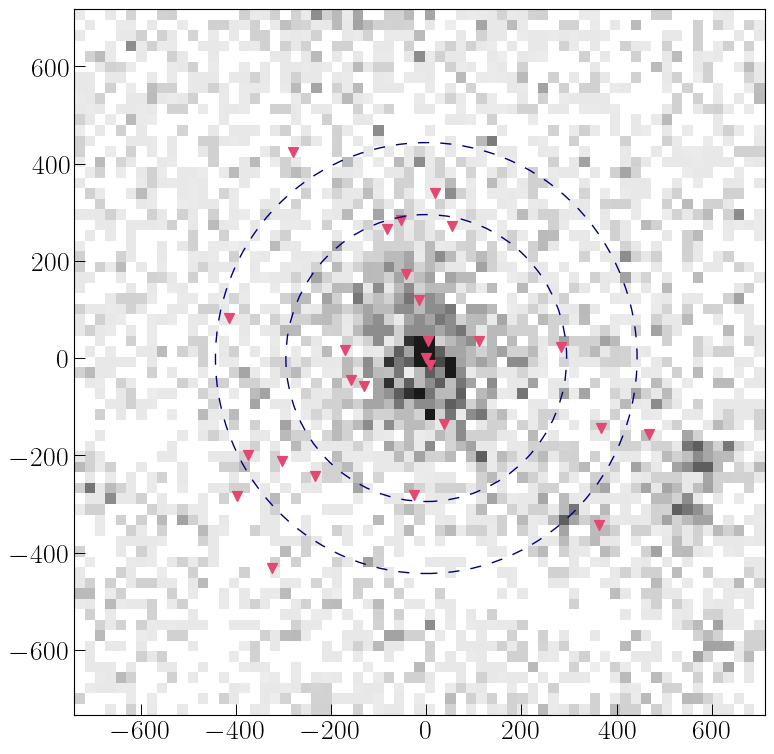

In [28]:

start_x, start_y = 380,394
size = 67

# Slice the image to get the square region
sliced_xray = xray_image[start_y:start_y + size, start_x:start_x + size]
x_xray, y_xray = np.meshgrid(delta_kpx_xr*np.linspace(-size/2, size/2, size)-xray_offset_x-10, delta_kpx_xr*np.linspace(-size/2, size/2, size)+xray_offset_y-10)
#x_xray, y_xray = np.meshgrid(delta_kpx_xr*np.linspace(-size/2, size/2, size) , delta_kpx_xr*np.linspace(-size/2, size/2, size))

width=8;height=8;ff, ax2 = plt.subplots(1,1);ff.set_figwidth(width);ff.set_figheight(height); ff.tight_layout(pad=1.0)
ax2.pcolormesh(x_xray, y_xray,sliced_xray,vmin=0.004, vmax= 10,cmap='gray_r', alpha=0.9, zorder=0)#, interpolation='none')
#ax.pcolormesh(xray_xp_mkpc,xray_yp_mkpc[::-1],xray_image,vmin=0.004, vmax= 10,cmap='gray_r', alpha=0.9, zorder=0)#, interpolation='none')

#ax2.scatter(-kpc_pos_m37[0], kpc_pos_m37[1],s=50, marker='.', c='navy')
ax2.scatter(-kpc_pos_m26[0], kpc_pos_m26[1],s=50, marker='v', c='#e44872')

# ax.set_xlim(-800,800)
# ax.set_ylim(-800,800)
# ax2.set_xlim(-800,800)
# ax2.set_ylim(-800,800)
circ_500 = plt.Circle((0,0),295,fill = False,color='navy', linestyle=(0,(8,8)), zorder=10)#, label=r'$r_{500}$')
#ax.add_patch(circ_500) 
ax2.add_patch(circ_500) 

circ_200 = plt.Circle((0,0),443,fill = False,color='navy', linestyle=(0,(8,8)), zorder=10)#, label=r'$r_{500}$')
#ax.add_patch(circ_200) 
ax2.add_patch(circ_200) 

#ax2.invert_xaxis()


plt.show()

In [29]:
# we now wish to create 2d density maps, first by scanning an aperture over the entire region:

# data of interest:

# we now have a sliced xray image to use for correlations:

xray_region = sliced_xray; xray_x_reg = x_xray; xray_y_reg = y_xray

# need the kpc positions as well as the masses of each galaxy: 

kpc_pos_m26_T=kpc_pos_m26.T;  m26_masses = 10**mem_data_m26[13]

In [30]:
max(x_xray[0]), min(x_xray[0]),max(y_xray.T[0]), min(y_xray[0])

(700.3272199969855, -728.4477799968478, 706.5677679968941, -722.2072319969392)

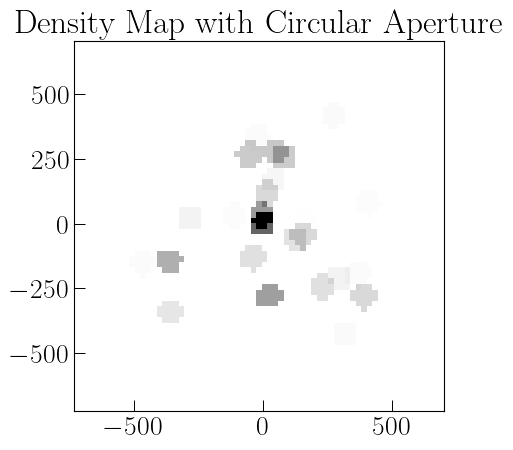

In [31]:
# here is an attempt at creating a density map: 

# first need a grid to generate a density for:

pos = kpc_pos_m26_T; aperture = 100

dens_x, dens_y = np.meshgrid(np.linspace(min(x_xray[0]), max(x_xray[0]), size),
                   np.linspace(min(y_xray[0]), max(y_xray.T[0]), size))
grid_points = np.vstack([dens_x.ravel(), dens_y.ravel()])

def circular_aperture(distances, aperture):
    return (distances <= aperture / 2).astype(float)

radial_dists = cdist(pos, grid_points.T)

values = circular_aperture(radial_dists, aperture=aperture)

density = np.dot(m26_masses, values)
density = density.reshape(dens_x.shape) / max(density)

# Plot the density map
plt.imshow(density, cmap='gray_r', origin='lower', extent=[min(x_xray[0]), max(x_xray[0]),
                   min(y_xray[0]), max(y_xray.T[0])])
plt.title('Density Map with Circular Aperture')

plt.show()

In [126]:
# now we want to make a function that will do this for us for arbirary apertures:

def circular_aperture(distances, aperture):
    return (np.abs(distances) <= aperture / 2).astype(float)

def gaussian_aperture(distances, aperture):
    return np.exp(-0.5 * (distances / aperture)**2) / (np.sqrt(2 * np.pi) * aperture)

def nfw_aperture(distances, aperture):
    return (1+(distances/aperture)**2)**(-1)#(1/(distances/aperture))
    


def make_density_map(aperture=10, mass_s=m26_masses, pos=kpc_pos_m26_T, weighting=circular_aperture):
    dens_x, dens_y = np.meshgrid(np.linspace(min(x_xray[0]), max(x_xray[0]), size),
                   np.linspace(min(y_xray[0]), max(y_xray.T[0]), size))
    grid_points = np.vstack([dens_x.ravel(), dens_y.ravel()])

    radial_dists = cdist(pos, grid_points.T)

    values = weighting(radial_dists, aperture=aperture)
    density = np.dot(mass_s, values)
    density = density.reshape(dens_x.shape) / max(density)

    return density


In [129]:
# data for plot of kernel difference:

r_kpc_plot = np.linspace(-500, 500, 5000)
a_plot = 100
gaus_plot = 100*gaussian_aperture(r_kpc_plot, a_plot/2)
circ_plot = circular_aperture(r_kpc_plot, a_plot)



In [136]:
ax1.fill_between?

Signature:
ax1.fill_between(
    x,
    y1,
    y2=0,
    where=None,
    interpolate=False,
    step=None,
    *,
    data=None,
    **kwargs,
)
Docstring:
Fill the area between two horizontal curves.

The curves are defined by the points (*x*, *y1*) and (*x*,
*y2*).  This creates one or multiple polygons describing the filled
area.

You may exclude some horizontal sections from filling using *where*.

By default, the edges connect the given points directly.  Use *step*
if the filling should be a step function, i.e. constant in between
*x*.

Parameters
----------
x : array (length N)
    The x coordinates of the nodes defining the curves.

y1 : array (length N) or scalar
    The y coordinates of the nodes defining the first curve.

y2 : array (length N) or scalar, default: 0
    The y coordinates of the nodes defining the second curve.

where : array of bool (length N), optional
    Define *where* to exclude some horizontal regions from being filled.
    The filled regions are defined

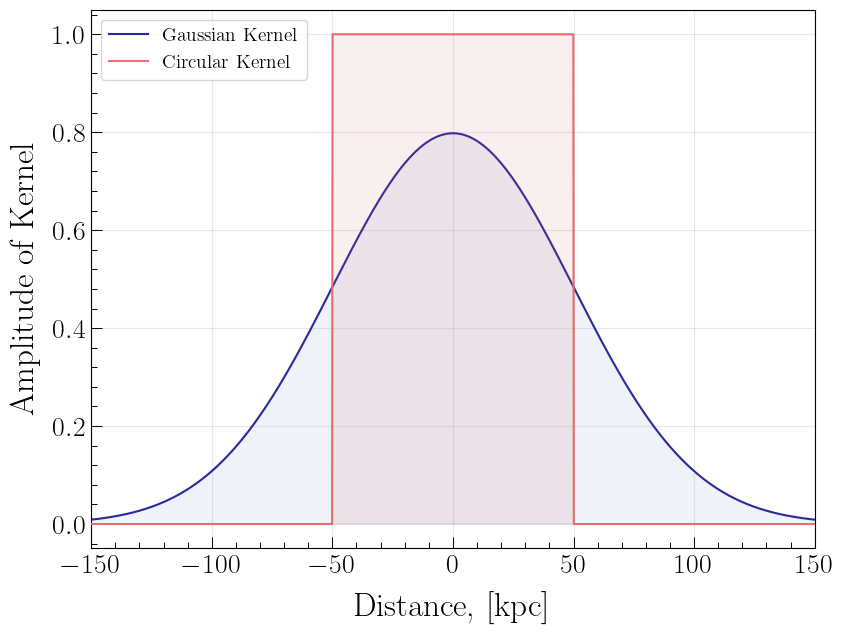

In [153]:
width=10;height=8;ff, ax1 = plt.subplots(1,1);ff.set_figwidth(width);ff.set_figheight(height);ff.tight_layout(pad=4.0)

# plotting this:
ax1.plot(r_kpc_plot, gaus_plot, c='#29299d', label='Gaussian Kernel')
ax1.plot(r_kpc_plot, circ_plot,c='#e87070', zorder=10, label='Circular Kernel')

ax1.fill_between(r_kpc_plot, 0, gaus_plot, alpha=0.1,color='#6a82cb')
ax1.fill_between(r_kpc_plot, 0, circ_plot, alpha=0.1,color='#cd645d',zorder=10)

# labels
#ax1.set_title(r"Mach Number for Increasing Line Pressures", pad = 15, fontsize=24)
ax1.set_ylabel(r"Amplitude of Kernel",labelpad =10, fontsize=24)
ax1.set_xlabel(r"Distance, [kpc]",labelpad =10,fontsize=24)

# ticks and legend:
ax1.yaxis.set_major_locator(MultipleLocator(0.2));ax1.yaxis.set_minor_locator(MultipleLocator(0.04))
ax1.xaxis.set_major_locator(MultipleLocator(50));ax1.xaxis.set_minor_locator(MultipleLocator(10))
ax1.grid(True, alpha=0.3, zorder=10)
ax1.legend( prop={'size': 14}, loc='upper left')
#ax1.set_ylim(1.025, 1.085)
ax1.set_xlim(-150, 150)
ax1.grid(True, zorder=0)

plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/5_kernel_differences", dpi=250)


In [33]:
# want to motivate the choice of aperture by finding the furthest distance between two galaxies:

#distances = np.sqrt(((kpc_pos_m26_T[:, None] - kpc_pos_m26_T) ** 2).sum(axis=2))
distances = cdist(kpc_pos_m26_T,kpc_pos_m26_T)
np.fill_diagonal(distances, np.inf)

nn_distances =np.min(distances, axis=1)
nn_mean = np.mean(nn_distances)
max_d_nn = np.max(nn_distances)
print(max_d_nn, nn_mean)

254.1429867406577 95.54278727025141


In [34]:
m26_masses

array([1.58489319e+11, 8.31763771e+10, 1.04712855e+11, 5.49540874e+10,
       1.00000000e+11, 1.02329299e+10, 3.98107171e+10, 5.37031796e+10,
       5.75439937e+10, 2.95120923e+10, 2.69153480e+10, 3.98107171e+10,
       1.25892541e+10, 1.31825674e+10, 5.49540874e+09, 3.31131121e+10,
       5.24807460e+09, 3.31131121e+10, 3.98107171e+10, 4.26579519e+09,
       5.12861384e+09, 1.73780083e+09, 2.88403150e+09, 3.16227766e+09,
       4.26579519e+09, 3.38844156e+09])

In [35]:
kpc_pos_m26_T

array([[   0.      ,    0.      ],
       [-366.438564, -144.849636],
       [  -3.654252,   34.945704],
       [ -54.19962 ,  272.441376],
       [  25.057728, -281.039616],
       [  43.390404,  173.592324],
       [ 397.300104, -282.851388],
       [  82.021068,  264.795084],
       [  52.265016,  284.294664],
       [ 130.04838 ,  -58.437324],
       [-362.292984, -344.144556],
       [  14.801256,  120.037572],
       [ 303.425748, -210.994668],
       [-282.636432,   23.399496],
       [ 280.425456,  423.61686 ],
       [ 234.332748, -241.702668],
       [ 324.522144, -431.75448 ],
       [ -37.279512, -134.593164],
       [ 158.883192,  -46.123416],
       [ -18.148428,  339.292692],
       [ 374.391936, -200.308284],
       [ 170.091612,   16.490196],
       [  -7.738416,  -14.463468],
       [-110.886588,   35.989776],
       [-468.726912, -155.750976],
       [ 414.496584,   83.034432]])

In [36]:
# need to generate the correct positions of the galaxies overlayed on the image:

# positions as of now:
red_pos_m26
#blue_pos_m26
#old_pos_m26
#young_pos_m26
#redex_pos_kpc_T


m26_pos = [[-kpc_pos_m26_T[i][0], kpc_pos_m26_T[i][1]] for i in range(len(kpc_pos_m26_T))]
red_pos = [[-red_pos_m26[i][0], red_pos_m26[i][1]] for i in range(len(red_pos_m26))]
blue_pos = [[-blue_pos_m26[i][0], blue_pos_m26[i][1]] for i in range(len(blue_pos_m26))]
old_pos = [[-old_pos_m26[i][0], old_pos_m26[i][1]] for i in range(len(old_pos_m26))]
young_pos = [[-young_pos_m26[i][0], young_pos_m26[i][1]] for i in range(len(young_pos_m26))]
redex_pos = [[-redex_pos_kpc_T[i][0], redex_pos_kpc_T[i][1]] for i in range(len(redex_pos_kpc_T))]

#redex_pos = redex_pos_kpc_T

In [37]:
# now we can run this for a bunch of apertures:

aps = np.linspace(10, 1000, 100)

densities_m26 = np.array([make_density_map(aps[i], pos=m26_pos) for i in range(len(aps))])
densities_red26 = np.array([make_density_map(aps[i],pos=red_pos,mass_s=10**red_mass_m26)for i in range(len(aps))])
densities_blue26 = np.array([make_density_map(aps[i],pos=blue_pos,mass_s=10**blue_mass_m26)for i in range(len(aps))])
densities_old26 = np.array([make_density_map(aps[i],pos=old_pos,mass_s=10**old_mass_m26)for i in range(len(aps))])
densities_young26 = np.array([make_density_map(aps[i],pos=young_pos,mass_s=10**young_mass_m26)for i in range(len(aps))])

densities_redex = np.array([make_density_map(aps[i],pos=redex_pos,mass_s=10**np.array(all_red_mass))for i in range(len(aps))])

dens_gauss_m26 = np.array([make_density_map(aps[i], pos=m26_pos,weighting=gaussian_aperture) for i in range(len(aps))])
dens_gauss_red26 = np.array([make_density_map(aps[i],pos=red_pos,mass_s=10**red_mass_m26,weighting=gaussian_aperture)for i in range(len(aps))])
dens_gauss_blue26 = np.array([make_density_map(aps[i],pos=blue_pos,mass_s=10**blue_mass_m26,weighting=gaussian_aperture)for i in range(len(aps))])
dens_gauss_old26 = np.array([make_density_map(aps[i],pos=old_pos,mass_s=10**old_mass_m26,weighting=gaussian_aperture)for i in range(len(aps))])
dens_gauss_young26 = np.array([make_density_map(aps[i],pos=young_pos,mass_s=10**young_mass_m26,weighting=gaussian_aperture)for i in range(len(aps))])
#aper_change_dense = np.array([make_density_map(aps[i],weighting=gaussian_aperture)/make_density_map(aps[i],weighting=gaussian_aperture).max() for i in range(len(aps))])

dens_redex_gauss = np.array([make_density_map(aps[i],pos=redex_pos,mass_s=10**np.array(all_red_mass), weighting=gaussian_aperture)for i in range(len(aps))])
dens_redex_nfw = np.array([make_density_map(aps[i],pos=redex_pos,mass_s=10**np.array(all_red_mass), weighting=nfw_aperture)for i in range(len(aps))])



dens_nfw_m26 = np.array([make_density_map(aps[i], pos=m26_pos,weighting=nfw_aperture) for i in range(len(aps))])
dens_nfw_red26 = np.array([make_density_map(aps[i],pos=red_pos,mass_s=10**red_mass_m26,weighting=nfw_aperture)for i in range(len(aps))])
dens_nfw_blue26 = np.array([make_density_map(aps[i],pos=blue_pos,mass_s=10**blue_mass_m26,weighting=nfw_aperture)for i in range(len(aps))])
dens_nfw_old26 = np.array([make_density_map(aps[i],pos=old_pos,mass_s=10**old_mass_m26,weighting=nfw_aperture)for i in range(len(aps))])
dens_nfw_young26 = np.array([make_density_map(aps[i],pos=young_pos,mass_s=10**young_mass_m26,weighting=nfw_aperture)for i in range(len(aps))])


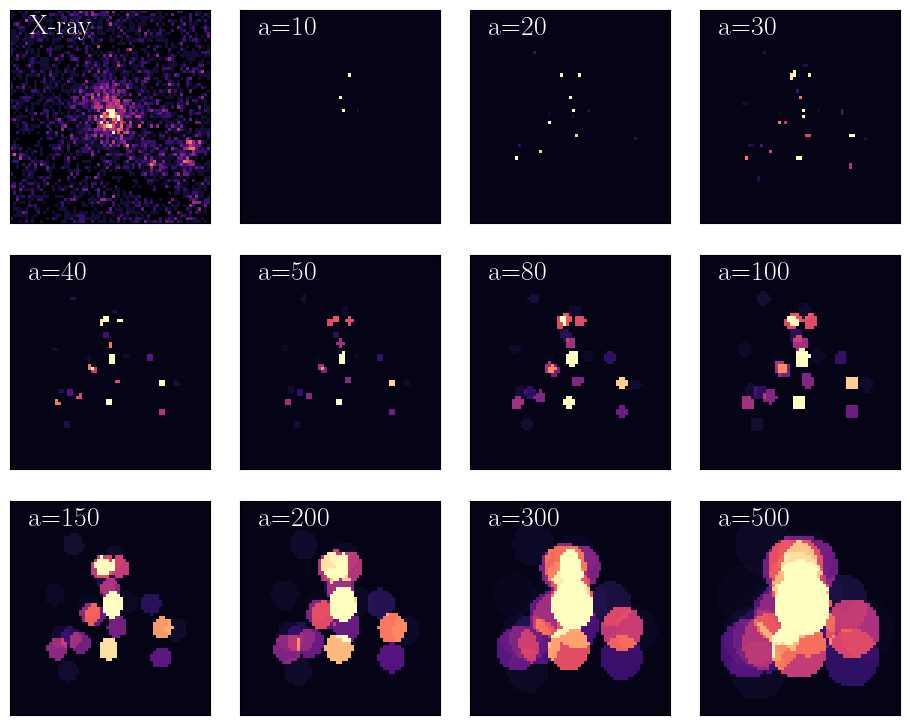

In [38]:
import matplotlib.colors as colors

width=10;height=8;ff, ax = plt.subplots(3,4);ff.set_figwidth(width);ff.set_figheight(height); ff.tight_layout(pad=1.0)
#ax2.pcolormesh(dens_x, dens_y,density, norm=colors.LogNorm(vmin=0.1, vmax=1,),cmap='gray_r', alpha=0.9, zorder=0)#, interpolation='none')
ax[0,0].pcolormesh(x_xray, y_xray,sliced_xray/sliced_xray.max(),vmin=0.001, vmax= 0.7,cmap='magma')
ax[0,1].pcolormesh(dens_x, dens_y,densities_m26[0], vmin=-0.015, vmax=0.35,cmap='magma', label="a=10") 
ax[0,2].pcolormesh(dens_x, dens_y,densities_m26[1], vmin=-0.015, vmax=0.35,cmap='magma', label="a=20") 
ax[0,3].pcolormesh(dens_x, dens_y,densities_m26[2], vmin=-0.015, vmax=0.35,cmap='magma', label="a=30") 
ax[1,0].pcolormesh(dens_x, dens_y,densities_m26[3], vmin=-0.015, vmax=0.35,cmap='magma', label="a=40") 
ax[1,1].pcolormesh(dens_x, dens_y,densities_m26[4], vmin=-0.015, vmax=0.35,cmap='magma', label="a=50") 
ax[1,2].pcolormesh(dens_x, dens_y,densities_m26[7], vmin=-0.015, vmax=0.35,cmap='magma', label="a=80") 
ax[1,3].pcolormesh(dens_x, dens_y,densities_m26[9], vmin=-0.015, vmax=0.35,cmap='magma', label="a=100") 
ax[2,0].pcolormesh(dens_x, dens_y,densities_m26[14],vmin=-0.015, vmax=0.35,cmap='magma', label="a=") 
ax[2,1].pcolormesh(dens_x, dens_y,densities_m26[19],vmin=-0.015, vmax=0.35,cmap='magma', label="a=") 
ax[2,2].pcolormesh(dens_x, dens_y,densities_m26[29],vmin=-0.015, vmax=0.35,cmap='magma', label="a=") 
ax[2,3].pcolormesh(dens_x, dens_y,densities_m26[39],vmin=-0.015, vmax=0.35,cmap='magma', label="a=") 


ax[0,0].text(-600, 550, 'X-ray',c='w')
ax[0,1].text(-600, 550, 'a=10' ,c='w')
ax[0,2].text(-600, 550, 'a=20' ,c='w')
ax[0,3].text(-600, 550, 'a=30' ,c='w')
ax[1,0].text(-600, 550, 'a=40' ,c='w')
ax[1,1].text(-600, 550, 'a=50' ,c='w')
ax[1,2].text(-600, 550, 'a=80' ,c='w')
ax[1,3].text(-600, 550, 'a=100',c='w')
ax[2,0].text(-600, 550, 'a=150',c='w')
ax[2,1].text(-600, 550, 'a=200',c='w')
ax[2,2].text(-600, 550, 'a=300',c='w')
ax[2,3].text(-600, 550, 'a=500',c='w')

for i in range(3):
    for j in range(4):
        # Plot on each subplot
        # Remove tick markers on both axes
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

plt.subplots_adjust(wspace=0.15) 
plt.subplots_adjust(hspace=0.15) 
#plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/5_m26_densities_11as", dpi=250)


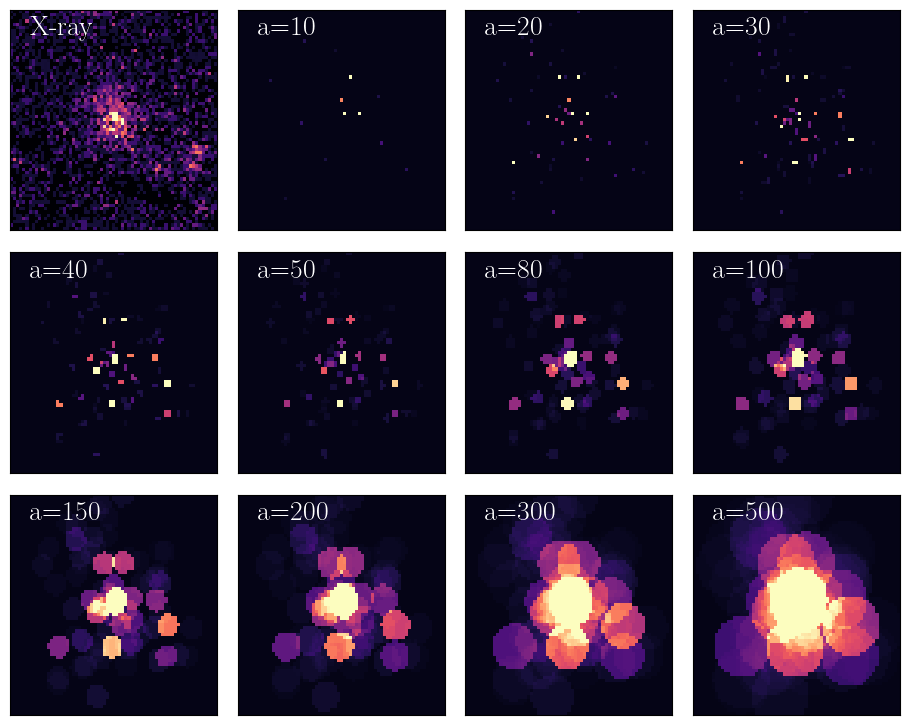

In [39]:
import matplotlib.colors as colors

width=10;height=8;ff, ax = plt.subplots(3,4);ff.set_figwidth(width);ff.set_figheight(height); ff.tight_layout(pad=1.0)
#ax2.pcolormesh(dens_x, dens_y,density, norm=colors.LogNorm(vmin=0.1, vmax=1,),cmap='gray_r', alpha=0.9, zorder=0)#, interpolation='none')
ax[0,0].pcolormesh(x_xray, y_xray,sliced_xray/sliced_xray.max(),vmin=0.001, vmax= 0.7,cmap='magma')
ax[0,1].pcolormesh(dens_x, dens_y,densities_redex[0], vmin=-0.015, vmax=0.35,cmap='magma', label="a=10") 
ax[0,2].pcolormesh(dens_x, dens_y,densities_redex[1], vmin=-0.015, vmax=0.35,cmap='magma', label="a=20") 
ax[0,3].pcolormesh(dens_x, dens_y,densities_redex[2], vmin=-0.015, vmax=0.35,cmap='magma', label="a=30") 
ax[1,0].pcolormesh(dens_x, dens_y,densities_redex[3], vmin=-0.015, vmax=0.35,cmap='magma', label="a=40") 
ax[1,1].pcolormesh(dens_x, dens_y,densities_redex[4], vmin=-0.015, vmax=0.35,cmap='magma', label="a=50") 
ax[1,2].pcolormesh(dens_x, dens_y,densities_redex[7], vmin=-0.015, vmax=0.35,cmap='magma', label="a=80") 
ax[1,3].pcolormesh(dens_x, dens_y,densities_redex[9], vmin=-0.015, vmax=0.35,cmap='magma', label="a=100") 
ax[2,0].pcolormesh(dens_x, dens_y,densities_redex[14],vmin=-0.015, vmax=0.35,cmap='magma', label="a=") 
ax[2,1].pcolormesh(dens_x, dens_y,densities_redex[19],vmin=-0.015, vmax=0.35,cmap='magma', label="a=") 
ax[2,2].pcolormesh(dens_x, dens_y,densities_redex[29],vmin=-0.015, vmax=0.35,cmap='magma', label="a=") 
ax[2,3].pcolormesh(dens_x, dens_y,densities_redex[39],vmin=-0.015, vmax=0.35,cmap='magma', label="a=") 


ax[0,0].text(-600, 550, 'X-ray',c='w')
ax[0,1].text(-600, 550, 'a=10' ,c='w')
ax[0,2].text(-600, 550, 'a=20' ,c='w')
ax[0,3].text(-600, 550, 'a=30' ,c='w')
ax[1,0].text(-600, 550, 'a=40' ,c='w')
ax[1,1].text(-600, 550, 'a=50' ,c='w')
ax[1,2].text(-600, 550, 'a=80' ,c='w')
ax[1,3].text(-600, 550, 'a=100',c='w')
ax[2,0].text(-600, 550, 'a=150',c='w')
ax[2,1].text(-600, 550, 'a=200',c='w')
ax[2,2].text(-600, 550, 'a=300',c='w')
ax[2,3].text(-600, 550, 'a=500',c='w')

for i in range(3):
    for j in range(4):
        # Plot on each subplot
        # Remove tick markers on both axes
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

plt.subplots_adjust(wspace=0.1) 
plt.subplots_adjust(hspace=0.1) 
#plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/5_redex_densities_11as", dpi=250)


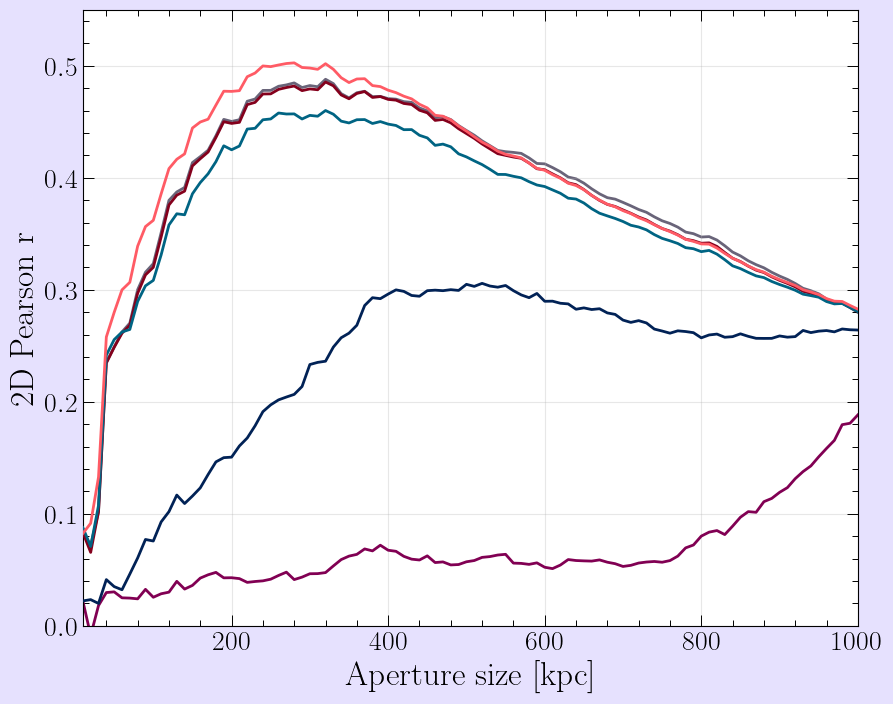

In [40]:

# now we can kind of haphazardly correlate all apertures:
xray_im_norm = sliced_xray/sliced_xray.max()
rs_2d = [pearsonr(xray_im_norm.flat, densities_m26[i].flat)[0] for i in range(len(aps))]
rs_2d_red = [pearsonr(xray_im_norm.flat, densities_red26[i].flat)[0] for i in range(len(aps))]
rs_2d_blue = [pearsonr(xray_im_norm.flat, densities_blue26[i].flat)[0] for i in range(len(aps))]
rs_2d_old = [pearsonr(xray_im_norm.flat, densities_old26[i].flat)[0] for i in range(len(aps))]
rs_2d_young = [pearsonr(xray_im_norm.flat, densities_young26[i].flat)[0] for i in range(len(aps))]
rs_2d_redex = [pearsonr(xray_im_norm.flat, densities_redex[i].flat)[0] for i in range(len(aps))]


ps_2d = [pearsonr(xray_im_norm.flat, densities_m26[i].flat)[1] for i in range(len(aps))]
ps_2d_red = [pearsonr(xray_im_norm.flat, densities_red26[i].flat)[1] for i in range(len(aps))]
ps_2d_blue = [pearsonr(xray_im_norm.flat, densities_blue26[i].flat)[1] for i in range(len(aps))]
ps_2d_old = [pearsonr(xray_im_norm.flat, densities_old26[i].flat)[1] for i in range(len(aps))]
ps_2d_young = [pearsonr(xray_im_norm.flat, densities_young26[i].flat)[1] for i in range(len(aps))]
ps_2d_redex = [pearsonr(xray_im_norm.flat, densities_redex[i].flat)[1] for i in range(len(aps))]



width=10;height=8;ff, ax1 = plt.subplots(1,1);ff.set_figwidth(width);ff.set_figheight(height)

#ax1.set_title("Radial Cumulative Galaxy Mass Distribution")
ax1.set_xlabel(r"Aperture size [kpc]", fontsize=24)
ax1.set_ylabel(r"2D Pearson r",fontsize=24)

ax1.plot(aps,rs_2d,      c=colours2[0], zorder=8, alpha=1,linewidth=2)
ax1.plot(aps,rs_2d_red,  c=colours2[1], zorder=6, alpha=1,linewidth=2)
ax1.plot(aps,rs_2d_blue, c=colours2[2], zorder=4, alpha=1,linewidth=2)
ax1.plot(aps,rs_2d_old,  c=colours2[3], zorder=0, alpha=1,linewidth=2)
ax1.plot(aps,rs_2d_young,c=colours2[4], zorder=2, alpha=1,linewidth=2)
ax1.plot(aps,rs_2d_redex,c=colours2[5], zorder=10, alpha=1,linewidth=2)



ax1.yaxis.set_major_locator(MultipleLocator(0.1));ax1.yaxis.set_minor_locator(MultipleLocator(0.02))
ax1.xaxis.set_major_locator(MultipleLocator(200));ax1.xaxis.set_minor_locator(MultipleLocator(40))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.3, zorder=10)
#ax1.legend()

ax1.set_xlim(10,1000)
ax1.set_ylim(0,0.55)

ff.set_facecolor('#e6e1fe')


plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/499_pearsonr_vs_aperture", dpi=250)


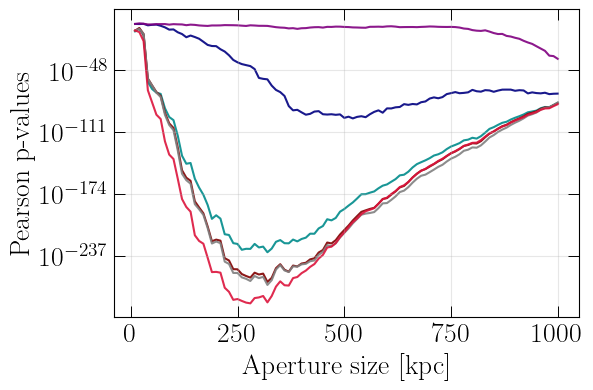

In [41]:
width=6;height=4;ff, ax1 = plt.subplots(1,1);ff.set_figwidth(width);ff.set_figheight(height)

#ax1.set_title("Radial Cumulative Galaxy Mass Distribution")
ax1.set_xlabel(r"Aperture size [kpc]")
ax1.set_ylabel(r"Pearson p-values")

ax1.semilogy(aps,ps_2d,c='darkcyan', zorder=1, alpha=0.9)
ax1.semilogy(aps,ps_2d_red,c='maroon', zorder=1, alpha=0.9)
ax1.semilogy(aps,ps_2d_blue,c='navy', zorder=1, alpha=0.9)
ax1.semilogy(aps,ps_2d_old,c='grey', zorder=1, alpha=0.9)
ax1.semilogy(aps,ps_2d_young,c='purple', zorder=1, alpha=0.9)
ax1.semilogy(aps,ps_2d_redex,c='crimson', zorder=1, alpha=0.9)



#ax1.yaxis.set_major_locator(MultipleLocator(0.1));ax1.yaxis.set_minor_locator(MultipleLocator(0.01))
#ax1.xaxis.set_major_locator(MultipleLocator(200));ax1.xaxis.set_minor_locator(MultipleLocator(20))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.3, zorder=10)
#ax1.legend()


plt.show()

In [42]:
from scipy import signal

# 2 dimensional correlations: 
cor_10 = signal.correlate2d (xray_im_norm, densities_m26[0])
cor_20 = signal.correlate2d (xray_im_norm, densities_m26[1])
cor_30 = signal.correlate2d (xray_im_norm, densities_m26[2])
cor_40 = signal.correlate2d (xray_im_norm, densities_m26[3])
cor_50 = signal.correlate2d (xray_im_norm, densities_m26[4])
cor_80 = signal.correlate2d (xray_im_norm, densities_m26[7])
cor_100 = signal.correlate2d (xray_im_norm, densities_m26[9])
cor_150 = signal.correlate2d (xray_im_norm, densities_m26[14])
cor_200 = signal.correlate2d (xray_im_norm, densities_m26[19])
cor_300 = signal.correlate2d (xray_im_norm, densities_m26[29])

cor_10_red  = signal.correlate2d (xray_im_norm, densities_red26[0])
cor_20_red  = signal.correlate2d (xray_im_norm, densities_red26[1])
cor_30_red  = signal.correlate2d (xray_im_norm, densities_red26[2])
cor_40_red  = signal.correlate2d (xray_im_norm, densities_red26[3])
cor_50_red  = signal.correlate2d (xray_im_norm, densities_red26[4])
cor_80_red  = signal.correlate2d (xray_im_norm, densities_red26[7])
cor_100_red = signal.correlate2d (xray_im_norm, densities_red26[9])
cor_150_red = signal.correlate2d (xray_im_norm, densities_red26[14])
cor_200_red = signal.correlate2d (xray_im_norm, densities_red26[19])
cor_300_red = signal.correlate2d (xray_im_norm, densities_red26[29])

cor_10_blue   = signal.correlate2d (xray_im_norm, densities_blue26[0])
cor_20_blue   = signal.correlate2d (xray_im_norm, densities_blue26[1])
cor_30_blue   = signal.correlate2d (xray_im_norm, densities_blue26[2])
cor_40_blue   = signal.correlate2d (xray_im_norm, densities_blue26[3])
cor_50_blue   = signal.correlate2d (xray_im_norm, densities_blue26[4])
cor_80_blue   = signal.correlate2d (xray_im_norm, densities_blue26[7])
cor_100_blue  = signal.correlate2d (xray_im_norm, densities_blue26[9])
cor_150_blue  = signal.correlate2d (xray_im_norm, densities_blue26[14])
cor_200_blue  = signal.correlate2d (xray_im_norm, densities_blue26[19])
cor_300_blue  = signal.correlate2d (xray_im_norm, densities_blue26[29])

cor_10_old  = signal.correlate2d (xray_im_norm, densities_old26[0])
cor_20_old  = signal.correlate2d (xray_im_norm, densities_old26[1])
cor_30_old  = signal.correlate2d (xray_im_norm, densities_old26[2])
cor_40_old  = signal.correlate2d (xray_im_norm, densities_old26[3])
cor_50_old  = signal.correlate2d (xray_im_norm, densities_old26[4])
cor_80_old  = signal.correlate2d (xray_im_norm, densities_old26[7])
cor_100_old = signal.correlate2d (xray_im_norm, densities_old26[9])
cor_150_old = signal.correlate2d (xray_im_norm, densities_old26[14])
cor_200_old = signal.correlate2d (xray_im_norm, densities_old26[19])
cor_300_old = signal.correlate2d (xray_im_norm, densities_old26[29])

cor_10_young  = signal.correlate2d (xray_im_norm, densities_young26[0])
cor_20_young  = signal.correlate2d (xray_im_norm, densities_young26[1])
cor_30_young  = signal.correlate2d (xray_im_norm, densities_young26[2])
cor_40_young  = signal.correlate2d (xray_im_norm, densities_young26[3])
cor_50_young  = signal.correlate2d (xray_im_norm, densities_young26[4])
cor_80_young  = signal.correlate2d (xray_im_norm, densities_young26[7])
cor_100_young = signal.correlate2d (xray_im_norm, densities_young26[9])
cor_150_young = signal.correlate2d (xray_im_norm, densities_young26[14])
cor_200_young = signal.correlate2d (xray_im_norm, densities_young26[19])
cor_300_young = signal.correlate2d (xray_im_norm, densities_young26[29])

cor_10_redex  = signal.correlate2d (xray_im_norm, densities_redex[0])
cor_20_redex  = signal.correlate2d (xray_im_norm, densities_redex[1])
cor_30_redex  = signal.correlate2d (xray_im_norm, densities_redex[2])
cor_40_redex  = signal.correlate2d (xray_im_norm, densities_redex[3])
cor_50_redex  = signal.correlate2d (xray_im_norm, densities_redex[4])
cor_80_redex  = signal.correlate2d (xray_im_norm, densities_redex[7])
cor_100_redex = signal.correlate2d (xray_im_norm, densities_redex[9])
cor_150_redex = signal.correlate2d (xray_im_norm, densities_redex[14])
cor_200_redex = signal.correlate2d (xray_im_norm, densities_redex[19])
cor_300_redex = signal.correlate2d (xray_im_norm, densities_redex[29])

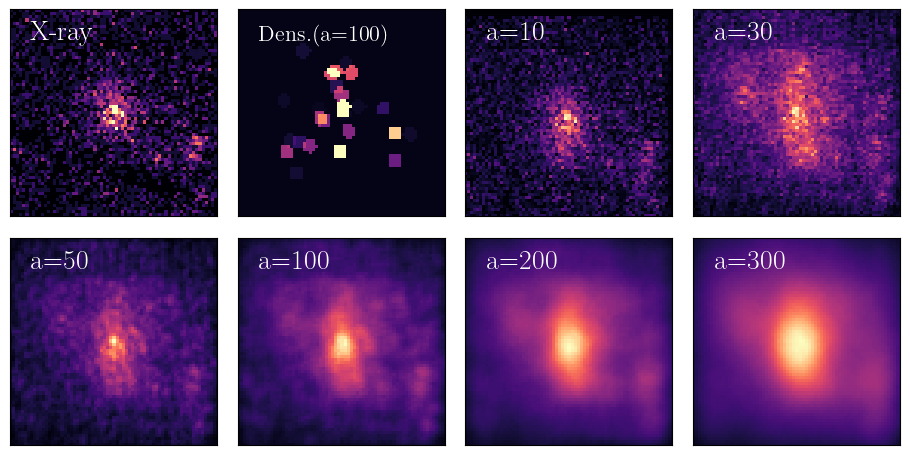

In [43]:
import matplotlib.colors as colors


width=10;height=8;ff, ax = plt.subplots(2,4,);ff.set_figwidth(width);ff.set_figheight(height); ff.tight_layout(pad=1.0)
#ax2.pcolormesh(dens_x, dens_y,density, norm=colors.LogNorm(vmin=0.1, vmax=1,),cmap='gray_r', alpha=0.9, zorder=0)#, interpolation='none')
ax[0,0].pcolormesh(x_xray, y_xray,sliced_xray/sliced_xray.max(),vmin=0.001, vmax= 0.7,cmap='magma')
ax[0,1].pcolormesh(dens_x, dens_y,densities_m26[9], vmin=-0.015, vmax=0.35,cmap='magma', label="a=100") 

ax[0,2].imshow(cor_10, cmap='magma', label="a=10") 
ax[0,3].imshow(cor_30, cmap='magma', label="a=20") 
ax[1,0].imshow(cor_50, cmap='magma', label="a=30") 
ax[1,1].imshow(cor_100, cmap='magma', label="a=40") 
ax[1,2].imshow(cor_200, cmap='magma', label="a=50") 
ax[1,3].imshow(cor_300, cmap='magma', label="a=80") 
# # ax[2,0].imshow(cor_100,cmap='magma', label="a=100") 
# # ax[2,1].imshow(cor_150,cmap='magma', label="a=") 
# # ax[2,2].imshow(cor_200,cmap='magma', label="a=") 
# # ax[2,3].imshow(cor_300,cmap='magma', label="a=") 

ax[0,2].set_xlim(32,100); ax[0,2].set_ylim(32,100)
ax[0,3].set_xlim(32,100); ax[0,3].set_ylim(32,100)
ax[1,0].set_xlim(32,100); ax[1,0].set_ylim(32,100)
ax[1,1].set_xlim(32,100); ax[1,1].set_ylim(32,100)
ax[1,2].set_xlim(32,100); ax[1,2].set_ylim(32,100)
ax[1,3].set_xlim(32,100); ax[1,3].set_ylim(32,100)
# ax[2,0].set_xlim(32,100); ax[2,0].set_ylim(28,102)
# ax[2,1].set_xlim(32,100); ax[2,1].set_ylim(28,102)
# ax[2,2].set_xlim(32,100); ax[2,2].set_ylim(28,102)
# ax[2,3].set_xlim(32,100); ax[2,3].set_ylim(28,102)


ax[0,0].text(-600, 500, 'X-ray',c='w')
ax[0,1].text(-600, 500, 'Dens.(a=100)' ,c='w', fontsize=16)
ax[0,2].text(39, 90, 'a=10' ,c='w')
ax[0,3].text(39, 90, 'a=30' ,c='w')
ax[1,0].text(39, 90, 'a=50' ,c='w')
ax[1,1].text(39, 90, 'a=100' ,c='w')
ax[1,2].text(39, 90, 'a=200' ,c='w')
ax[1,3].text(39, 90, 'a=300',c='w')


for i in range(2):
    for j in range(4):
        # Plot on each subplot
        # Remove tick markers on both axes
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

plt.subplots_adjust(wspace=0.1) 
plt.subplots_adjust(hspace=-0.52) 
ax[0, 0].set_aspect('equal')
ax[0, 1].set_aspect('equal')
#plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/5_2d_spatial_correlation_all", dpi=250)



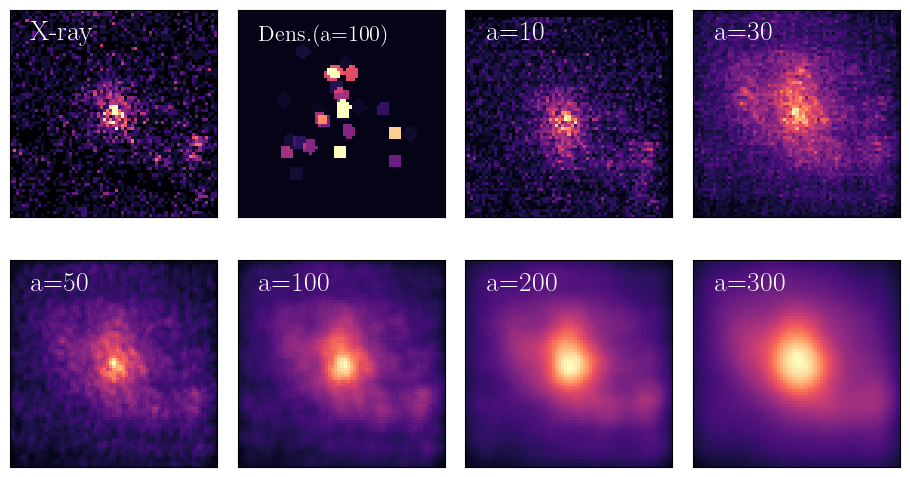

In [44]:
import matplotlib.colors as colors


width=10;height=8;ff, ax = plt.subplots(2,4);ff.set_figwidth(width);ff.set_figheight(height); ff.tight_layout(pad=1.0)
#ax2.pcolormesh(dens_x, dens_y,density, norm=colors.LogNorm(vmin=0.1, vmax=1,),cmap='gray_r', alpha=0.9, zorder=0)#, interpolation='none')
ax[0,0].pcolormesh(x_xray, y_xray,sliced_xray/sliced_xray.max(),vmin=0.001, vmax= 0.7,cmap='magma')
ax[0,1].pcolormesh(dens_x, dens_y,densities_m26[9], vmin=-0.015, vmax=0.35,cmap='magma', label="a=100") 

ax[0,2].imshow( cor_10_redex  , cmap='magma', label="a=10") 
ax[0,3].imshow( cor_30_redex  , cmap='magma', label="a=20") 
ax[1,0].imshow( cor_50_redex  , cmap='magma', label="a=30") 
ax[1,1].imshow( cor_100_redex  , cmap='magma', label="a=40") 
ax[1,2].imshow( cor_200_redex  , cmap='magma', label="a=50") 
ax[1,3].imshow( cor_300_redex  , cmap='magma', label="a=80") 
# ax[2,0].imshow(cor_100_redex,cmap='magma', label="a=100") 
# ax[2,1].imshow(cor_150_redex,cmap='magma', label="a=") 
# ax[2,2].imshow(cor_200_redex,cmap='magma', label="a=") 
# ax[2,3].imshow(cor_300_redex,cmap='magma', label="a=") 

ax[0,2].set_xlim(32,100); ax[0,2].set_ylim(32,100)
ax[0,3].set_xlim(32,100); ax[0,3].set_ylim(32,100)
ax[1,0].set_xlim(32,100); ax[1,0].set_ylim(32,100)
ax[1,1].set_xlim(32,100); ax[1,1].set_ylim(32,100)
ax[1,2].set_xlim(32,100); ax[1,2].set_ylim(32,100)
ax[1,3].set_xlim(32,100); ax[1,3].set_ylim(32,100)
# ax[2,0].set_xlim(32,100); ax[2,0].set_ylim(28,102)
# ax[2,1].set_xlim(32,100); ax[2,1].set_ylim(28,102)
# ax[2,2].set_xlim(32,100); ax[2,2].set_ylim(28,102)
# ax[2,3].set_xlim(32,100); ax[2,3].set_ylim(28,102)


ax[0,0].text(-600, 500, 'X-ray',c='w')
ax[0,1].text(-600, 500, 'Dens.(a=100)' ,c='w', fontsize=16)
ax[0,2].text(39, 90, 'a=10' ,c='w')
ax[0,3].text(39, 90, 'a=30' ,c='w')
ax[1,0].text(39, 90, 'a=50' ,c='w')
ax[1,1].text(39, 90, 'a=100' ,c='w')
ax[1,2].text(39, 90, 'a=200' ,c='w')
ax[1,3].text(39, 90, 'a=300',c='w')


for i in range(2):
    for j in range(4):
        # Plot on each subplot
        # Remove tick markers on both axes
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

plt.subplots_adjust(wspace=0.1) 
plt.subplots_adjust(hspace=-0.45) 
ax[0, 0].set_aspect('equal')
ax[0, 1].set_aspect('equal')
#plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/5_2d_spatial_correlation_redex", dpi=250)

plt.show()

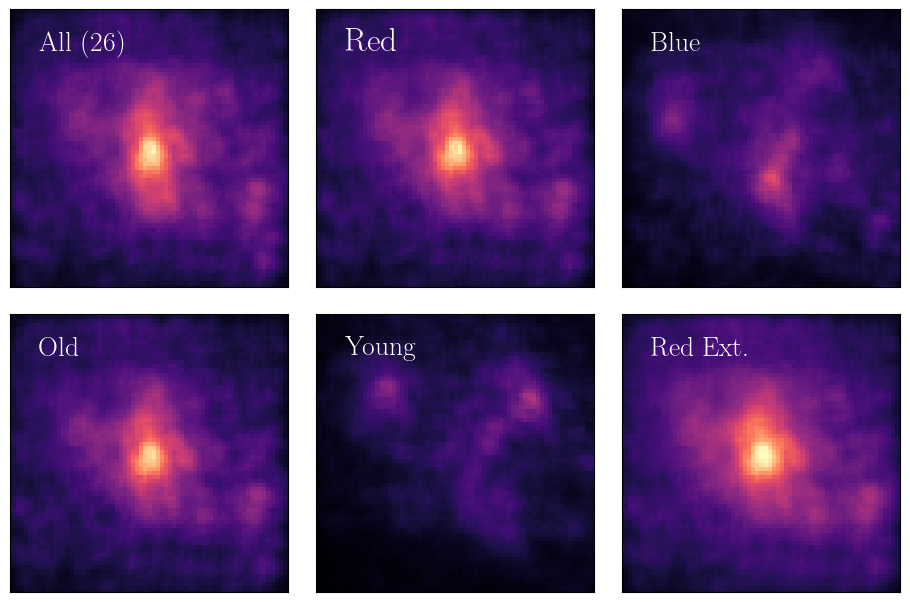

In [52]:
import matplotlib.colors as colors


width=10;height=8;ff, ax = plt.subplots(2,3);ff.set_figwidth(width);ff.set_figheight(height); ff.tight_layout(pad=1.0)
#ax2.pcolormesh(dens_x, dens_y,density, norm=colors.LogNorm(vmin=0.1, vmax=1,),cmap='gray_r', alpha=0.9, zorder=0)#, interpolation='none')
#ax[0,0].pcolormesh(x_xray, y_xray,sliced_xray/sliced_xray.max(),vmin=0.001, vmax= 0.7,cmap='magma')
#ax[0,1].pcolormesh(dens_x, dens_y,densities_m26[9], vmin=-0.015, vmax=0.35,cmap='magma', label="a=100") 

ax[0,0].imshow( cor_100  , cmap='magma',      label="a=10",vmin=0, vmax=14) 
ax[0,1].imshow( cor_100_red  , cmap='magma',  label="a=20",vmin=0, vmax=14) 
ax[0,2].imshow( cor_100_blue  , cmap='magma', label="a=30",vmin=0, vmax=26) 
ax[1,0].imshow( cor_100_old  , cmap='magma',  label="a=40",vmin=0, vmax=14) 
ax[1,1].imshow( cor_100_young  , cmap='magma',label="a=50",vmin=0, vmax=22) 
ax[1,2].imshow( cor_100_redex  , cmap='magma',label="a=80",vmin=0, vmax=14) 
# ax[2,0].imshow(cor_100_redex,cmap='magma', label="a=100") 
# ax[2,1].imshow(cor_150_redex,cmap='magma', label="a=") 
# ax[2,2].imshow(cor_200_redex,cmap='magma', label="a=") 
# ax[2,3].imshow(cor_300_redex,cmap='magma', label="a=") 


ax[0,0].set_xlim(32,100); ax[0,0].set_ylim(32,100)
ax[0,1].set_xlim(32,100); ax[0,1].set_ylim(32,100)

ax[0,2].set_xlim(32,100); ax[0,2].set_ylim(32,100)
ax[1,0].set_xlim(32,100); ax[1,0].set_ylim(32,100)
ax[1,1].set_xlim(32,100); ax[1,1].set_ylim(32,100)
ax[1,2].set_xlim(32,100); ax[1,2].set_ylim(32,100)
# ax[2,0].set_xlim(32,100); ax[2,0].set_ylim(28,102)
# ax[2,1].set_xlim(32,100); ax[2,1].set_ylim(28,102)
# ax[2,2].set_xlim(32,100); ax[2,2].set_ylim(28,102)
# ax[2,3].set_xlim(32,100); ax[2,3].set_ylim(28,102)


ax[0,0].text(39,90, 'All (26)',c='w')
ax[0,1].text(39,90, 'Red' ,c='w', fontsize=24)
ax[0,2].text(39, 90, 'Blue' ,c='w')
ax[1,0].text(39, 90, 'Old',c='w')
ax[1,1].text(39, 90, 'Young',c='w')
ax[1,2].text(39, 90, 'Red Ext.' ,c='w')


for i in range(2):
    for j in range(3):
        # Plot on each subplot
        # Remove tick markers on both axes
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

plt.subplots_adjust(wspace=0.1) 
plt.subplots_adjust(hspace=-0.24) 
#ax[0, 0].set_aspect('equal')
#ax[0, 1].set_aspect('equal')
plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/5_2d_spatial_corr_a100_6samps", dpi=250)

plt.show()

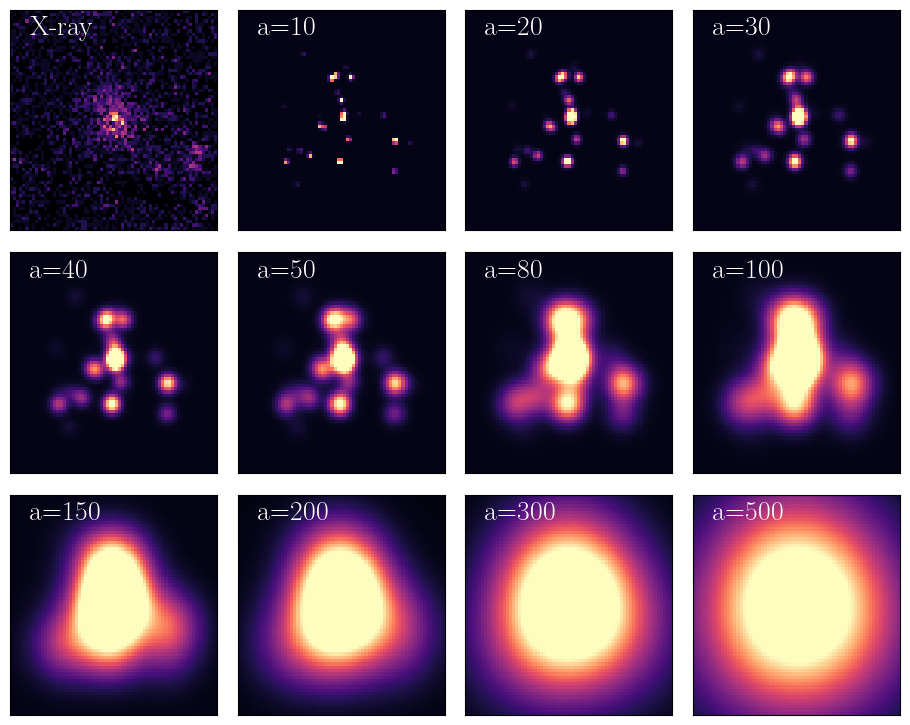

In [53]:
import matplotlib.colors as colors

# 2 dimensional correlations: 
# cor_gau_10 = signal.correlate2d (xray_im_norm,  dens_gauss_m26[0])
# cor_gau_20 = signal.correlate2d (xray_im_norm,  dens_gauss_m26[1])
# cor_gau_30 = signal.correlate2d (xray_im_norm,  dens_gauss_m26[2])
# cor_gau_40 = signal.correlate2d (xray_im_norm,  dens_gauss_m26[3])
# cor_gau_50 = signal.correlate2d (xray_im_norm,  dens_gauss_m26[4])
# cor_gau_80 = signal.correlate2d (xray_im_norm,  dens_gauss_m26[7])
# cor_gau_100 = signal.correlate2d (xray_im_norm, dens_gauss_m26[9])
# cor_gau_150 = signal.correlate2d (xray_im_norm, dens_gauss_m26[14])
# cor_gau_200 = signal.correlate2d (xray_im_norm, dens_gauss_m26[19])
# cor_gau_300 = signal.correlate2d (xray_im_norm, dens_gauss_m26[29])


width=10;height=8;ff, ax = plt.subplots(3,4);ff.set_figwidth(width);ff.set_figheight(height); ff.tight_layout(pad=1.0)
#ax2.pcolormesh(dens_x, dens_y,density, norm=colors.LogNorm(vmin=0.1, vmax=1,),cmap='gray_r', alpha=0.9, zorder=0)#, interpolation='none')
ax[0,0].pcolormesh(x_xray, y_xray,sliced_xray/sliced_xray.max(),vmin=0.001, vmax= 1,cmap='magma')
ax[0,1].pcolormesh(dens_x, dens_y,dens_gauss_m26[0],vmin=-0.015, vmax=0.35,cmap='magma', label="a=10") 
ax[0,2].pcolormesh(dens_x, dens_y,dens_gauss_m26[1],vmin=-0.015, vmax=0.35,cmap='magma', label="a=20") 
ax[0,3].pcolormesh(dens_x, dens_y,dens_gauss_m26[2],vmin=-0.015, vmax=0.35,cmap='magma', label="a=30") 
ax[1,0].pcolormesh(dens_x, dens_y,dens_gauss_m26[3],vmin=-0.015, vmax=0.35,cmap='magma', label="a=40") 
ax[1,1].pcolormesh(dens_x, dens_y,dens_gauss_m26[4],vmin=-0.015, vmax=0.35,cmap='magma', label="a=50") 
ax[1,2].pcolormesh(dens_x, dens_y,dens_gauss_m26[7],vmin=-0.015, vmax=0.35,cmap='magma', label="a=80") 
ax[1,3].pcolormesh(dens_x, dens_y,dens_gauss_m26[9],vmin=-0.015, vmax=0.35,cmap='magma', label="a=100") 

ax[2,0].pcolormesh(dens_x, dens_y,dens_gauss_m26[14],vmin=-0.015, vmax=0.4,cmap='magma',  label="a=") 
ax[2,1].pcolormesh(dens_x, dens_y,dens_gauss_m26[19],vmin=-0.015, vmax=0.5,cmap='magma',  label="a=") 
ax[2,2].pcolormesh(dens_x, dens_y,dens_gauss_m26[29],vmin=-0.015, vmax=0.6,cmap='magma',  label="a=") 
ax[2,3].pcolormesh(dens_x, dens_y,dens_gauss_m26[39],vmin=-0.015, vmax=0.7,cmap='magma',  label="a=") 

ax[0,0].text(-600, 550, 'X-ray',c='w')
ax[0,1].text(-600, 550, 'a=10' ,c='w')
ax[0,2].text(-600, 550, 'a=20' ,c='w')
ax[0,3].text(-600, 550, 'a=30' ,c='w')
ax[1,0].text(-600, 550, 'a=40' ,c='w')
ax[1,1].text(-600, 550, 'a=50' ,c='w')
ax[1,2].text(-600, 550, 'a=80' ,c='w')
ax[1,3].text(-600, 550, 'a=100',c='w')
ax[2,0].text(-600, 550, 'a=150',c='w')
ax[2,1].text(-600, 550, 'a=200',c='w')
ax[2,2].text(-600, 550, 'a=300',c='w')
ax[2,3].text(-600, 550, 'a=500',c='w')

for i in range(3):
    for j in range(4):
        # Plot on each subplot
        # Remove tick markers on both axes
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

plt.subplots_adjust(wspace=0.1) 
plt.subplots_adjust(hspace=0.1) 
#plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/5_m26_gauss_densities_11as", dpi=250)


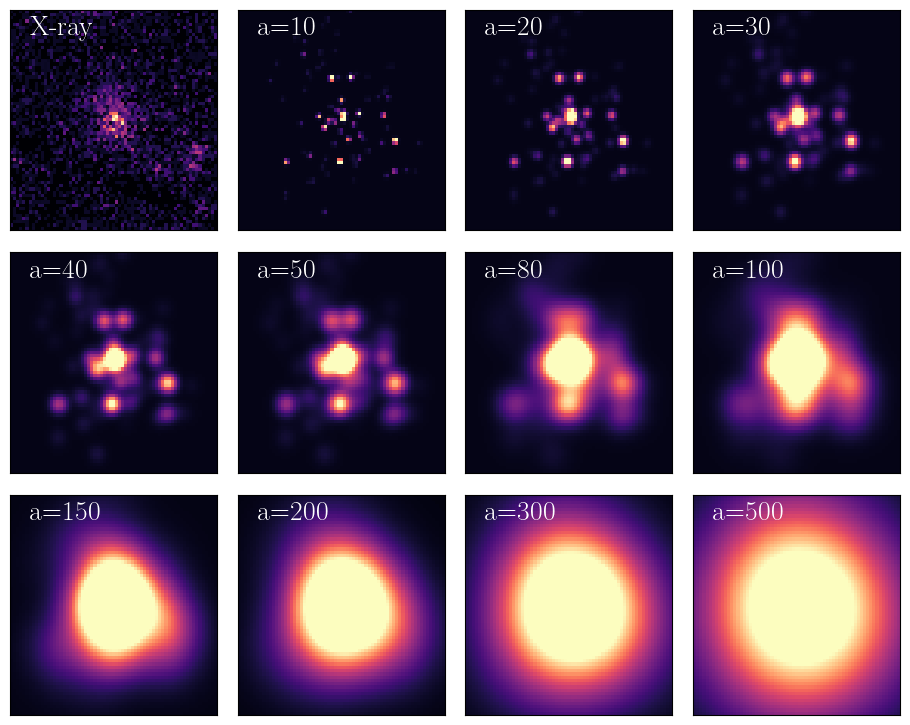

In [54]:
width=10;height=8;ff, ax = plt.subplots(3,4);ff.set_figwidth(width);ff.set_figheight(height); ff.tight_layout(pad=1.0)
#ax2.pcolormesh(dens_x, dens_y,density, norm=colors.LogNorm(vmin=0.1, vmax=1,),cmap='gray_r', alpha=0.9, zorder=0)#, interpolation='none')
ax[0,0].pcolormesh(x_xray, y_xray,sliced_xray/sliced_xray.max(),vmin=0.001, vmax= 1,cmap='magma')
ax[0,1].pcolormesh(dens_x, dens_y,dens_redex_gauss[0],vmin=-0.015, vmax=0.35,cmap='magma', label="a=10") 
ax[0,2].pcolormesh(dens_x, dens_y,dens_redex_gauss[1],vmin=-0.015, vmax=0.35,cmap='magma', label="a=20") 
ax[0,3].pcolormesh(dens_x, dens_y,dens_redex_gauss[2],vmin=-0.015, vmax=0.35,cmap='magma', label="a=30") 
ax[1,0].pcolormesh(dens_x, dens_y,dens_redex_gauss[3],vmin=-0.015, vmax=0.35,cmap='magma', label="a=40") 
ax[1,1].pcolormesh(dens_x, dens_y,dens_redex_gauss[4],vmin=-0.015, vmax=0.35,cmap='magma', label="a=50") 
ax[1,2].pcolormesh(dens_x, dens_y,dens_redex_gauss[7],vmin=-0.015, vmax=0.35,cmap='magma', label="a=80") 
ax[1,3].pcolormesh(dens_x, dens_y,dens_redex_gauss[9],vmin=-0.015, vmax=0.35,cmap='magma', label="a=100") 

ax[2,0].pcolormesh(dens_x, dens_y,dens_redex_gauss[14],vmin=-0.015, vmax=0.4,cmap='magma',  label="a=") 
ax[2,1].pcolormesh(dens_x, dens_y,dens_redex_gauss[19],vmin=-0.015, vmax=0.5,cmap='magma',  label="a=") 
ax[2,2].pcolormesh(dens_x, dens_y,dens_redex_gauss[29],vmin=-0.015, vmax=0.6,cmap='magma',  label="a=") 
ax[2,3].pcolormesh(dens_x, dens_y,dens_redex_gauss[39],vmin=-0.015, vmax=0.7,cmap='magma',  label="a=") 

ax[0,0].text(-600, 550, 'X-ray',c='w')
ax[0,1].text(-600, 550, 'a=10' ,c='w')
ax[0,2].text(-600, 550, 'a=20' ,c='w')
ax[0,3].text(-600, 550, 'a=30' ,c='w')
ax[1,0].text(-600, 550, 'a=40' ,c='w')
ax[1,1].text(-600, 550, 'a=50' ,c='w')
ax[1,2].text(-600, 550, 'a=80' ,c='w')
ax[1,3].text(-600, 550, 'a=100',c='w')
ax[2,0].text(-600, 550, 'a=150',c='w')
ax[2,1].text(-600, 550, 'a=200',c='w')
ax[2,2].text(-600, 550, 'a=300',c='w')
ax[2,3].text(-600, 550, 'a=500',c='w')

for i in range(3):
    for j in range(4):
        # Plot on each subplot
        # Remove tick markers on both axes
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

plt.subplots_adjust(wspace=0.1) 
plt.subplots_adjust(hspace=0.1) 
#plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/5_redex_gauss_densities_11as", dpi=250)


(0.0, 0.55)

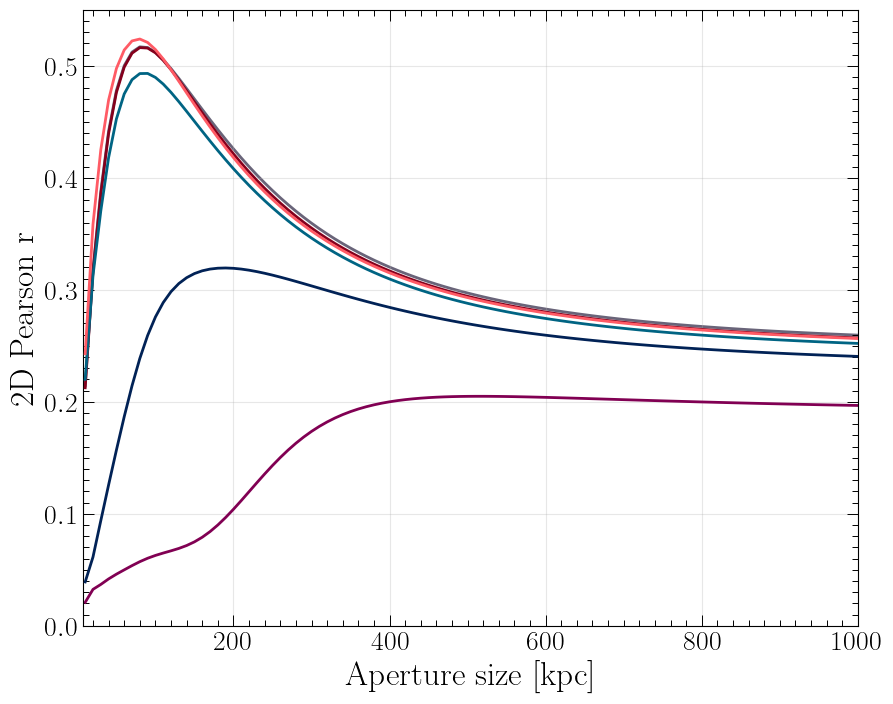

In [55]:
rs_2d_gau = [np.corrcoef(xray_im_norm.flat, dens_gauss_m26[i].flat)[0,1] for i in range(len(aps))]
rs_2d_gau_red = [np.corrcoef(xray_im_norm.flat, dens_gauss_red26[i].flat)[0,1] for i in range(len(aps))]
rs_2d_gau_blue = [np.corrcoef(xray_im_norm.flat, dens_gauss_blue26[i].flat)[0,1] for i in range(len(aps))]
rs_2d_gau_old = [np.corrcoef(xray_im_norm.flat, dens_gauss_old26[i].flat)[0,1] for i in range(len(aps))]
rs_2d_gau_young = [np.corrcoef(xray_im_norm.flat, dens_gauss_young26[i].flat)[0,1] for i in range(len(aps))]
rs_2d_gau_redex = [np.corrcoef(xray_im_norm.flat, dens_redex_gauss[i].flat)[0,1] for i in range(len(aps))]

width=10;height=8;ff, ax1 = plt.subplots(1,1);ff.set_figwidth(width);ff.set_figheight(height)

#ax1.set_title("Radial Cumulative Galaxy Mass Distribution")
ax1.set_xlabel(r"Aperture size [kpc]",fontsize=24)
ax1.set_ylabel(r"2D Pearson r",fontsize=24)

ax1.plot(aps,rs_2d_gau, c=colours2[0], zorder=8, alpha=1,linewidth=2)
ax1.plot(aps,rs_2d_gau_red,c=colours2[1], zorder=6, alpha=1,linewidth=2)
ax1.plot(aps,rs_2d_gau_blue,c=colours2[2], zorder=4, alpha=1,linewidth=2)
ax1.plot(aps,rs_2d_gau_old,c=colours2[3], zorder=0, alpha=1,linewidth=2)
ax1.plot(aps,rs_2d_gau_young,c=colours2[4], zorder=2, alpha=1,linewidth=2)
ax1.plot(aps,rs_2d_gau_redex,c=colours2[5], zorder=10, alpha=1,linewidth=2)



ax1.yaxis.set_major_locator(MultipleLocator(0.1));ax1.yaxis.set_minor_locator(MultipleLocator(0.01))
ax1.xaxis.set_major_locator(MultipleLocator(200));ax1.xaxis.set_minor_locator(MultipleLocator(20))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.3, zorder=0)
#ax1.legend()
ax1.set_xlim(7,1000)
ax1.set_ylim(0,0.55)


#plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/5_pearsonr_vs_aperture_gauss", dpi=250)


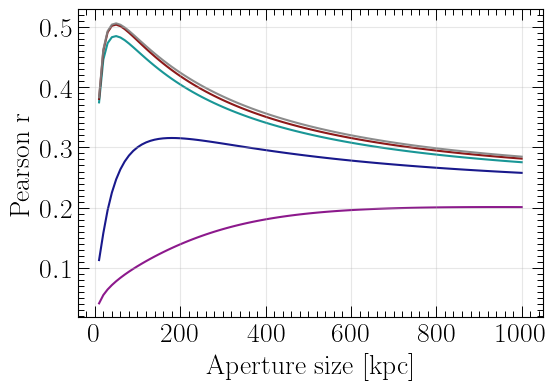

In [56]:
rs_2d_nfw = [np.corrcoef(xray_im_norm.flat, dens_nfw_m26[i].flat)[0,1] for i in range(len(aps))]
rs_2d_nfw_red = [np.corrcoef(xray_im_norm.flat, dens_nfw_red26[i].flat)[0,1] for i in range(len(aps))]
rs_2d_nfw_blue = [np.corrcoef(xray_im_norm.flat, dens_nfw_blue26[i].flat)[0,1] for i in range(len(aps))]
rs_2d_nfw_old = [np.corrcoef(xray_im_norm.flat, dens_nfw_old26[i].flat)[0,1] for i in range(len(aps))]
rs_2d_nfw_young = [np.corrcoef(xray_im_norm.flat, dens_nfw_young26[i].flat)[0,1] for i in range(len(aps))]

width=6;height=4;ff, ax1 = plt.subplots(1,1);ff.set_figwidth(width);ff.set_figheight(height)

#ax1.set_title("Radial Cumulative Galaxy Mass Distribution")
ax1.set_xlabel(r"Aperture size [kpc]")
ax1.set_ylabel(r"Pearson r")

ax1.plot(aps,rs_2d_nfw,c='darkcyan', zorder=1, alpha=0.9)
ax1.plot(aps,rs_2d_nfw_red,c='maroon', zorder=1, alpha=0.9)
ax1.plot(aps,rs_2d_nfw_blue,c='navy', zorder=1, alpha=0.9)
ax1.plot(aps,rs_2d_nfw_old,c='grey', zorder=1, alpha=0.9)
ax1.plot(aps,rs_2d_nfw_young,c='purple', zorder=1, alpha=0.9)
ax1.yaxis.set_major_locator(MultipleLocator(0.1));ax1.yaxis.set_minor_locator(MultipleLocator(0.01))
ax1.xaxis.set_major_locator(MultipleLocator(200));ax1.xaxis.set_minor_locator(MultipleLocator(20))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.3, zorder=10)
#ax1.legend()

plt.show()

In [57]:
#np.amax(dens_gauss_m26[5])
np.amax(dens_gauss_red26[5])

1.0

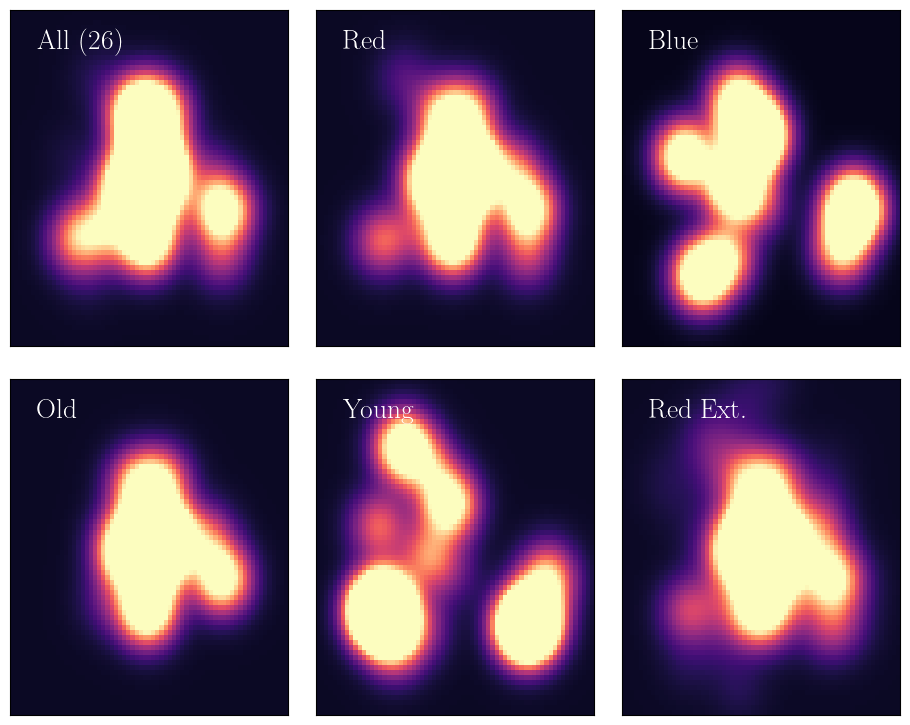

In [58]:
width=10;height=8;ff, ax = plt.subplots(2,3);ff.set_figwidth(width);ff.set_figheight(height); ff.tight_layout(pad=1.0)
#ax2.pcolormesh(dens_x, dens_y,density, norm=colors.LogNorm(vmin=0.1, vmax=1,),cmap='gray_r', alpha=0.9, zorder=0)#, interpolation='none')
ax[0,0].pcolormesh(dens_x, dens_y,    dens_gauss_m26[9],vmin=-0.015, vmax=0.2,cmap='magma', label="a=10") 
ax[0,1].pcolormesh(dens_x, dens_y,  dens_gauss_red26[9],vmin=-0.015, vmax=0.2,cmap='magma', label="a=10") 
ax[0,2].pcolormesh(dens_x, dens_y, dens_gauss_blue26[9],vmin=-0.015, vmax=0.3,cmap='magma', label="a=20") 
ax[1,0].pcolormesh(dens_x, dens_y,  dens_gauss_old26[9],vmin=-0.015, vmax=0.2,cmap='magma', label="a=40") 
ax[1,1].pcolormesh(dens_x, dens_y,dens_gauss_young26[9],vmin=-0.015, vmax=0.2,cmap='magma', label="a=50") 
ax[1,2].pcolormesh(dens_x, dens_y,  dens_redex_gauss[9],vmin=-0.015, vmax=0.2,cmap='magma', label="a=80") 

#ff.suptitle("a=100 kpc")

ax[0,0].text(-600, 550, 'All (26)',c='w')
ax[0,1].text(-600, 550, 'Red' ,c='w')
ax[0,2].text(-600, 550, 'Blue' ,c='w')
ax[1,0].text(-600, 550, 'Old' ,c='w')
ax[1,1].text(-600, 550, 'Young' ,c='w')
ax[1,2].text(-600, 550, 'Red Ext.' ,c='w')


for i in range(2):
    for j in range(3):
        # Plot on each subplot
        # Remove tick markers on both axes
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

plt.subplots_adjust(wspace=0.1) 
plt.subplots_adjust(hspace=0.1) 
#plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/5XA_a=100_density_maps_6samps", dpi=250)


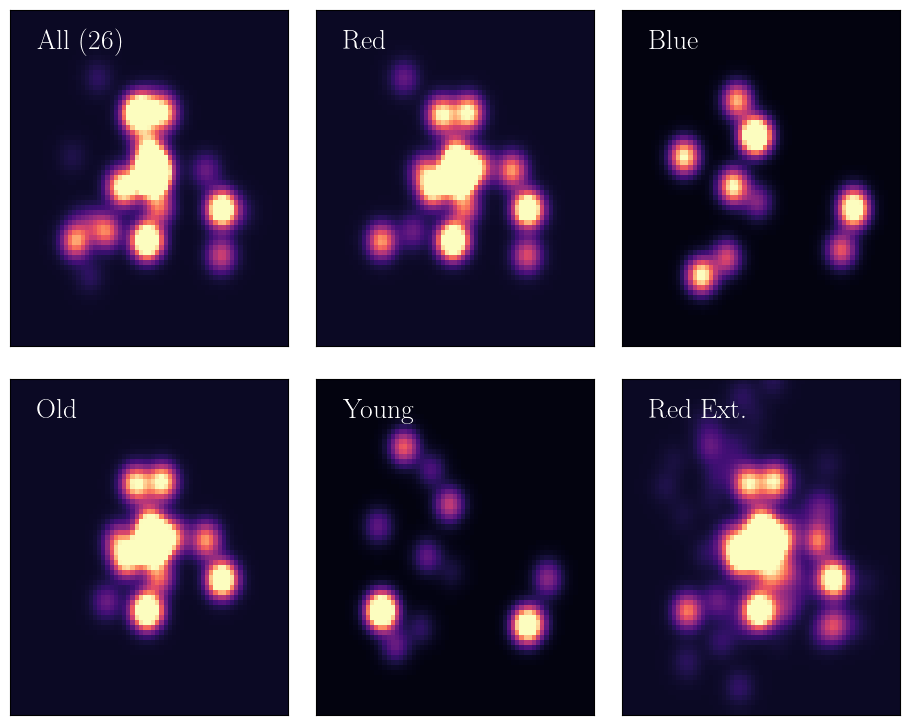

In [66]:
width=10;height=8;ff, ax = plt.subplots(2,3);ff.set_figwidth(width);ff.set_figheight(height); ff.tight_layout(pad=1.0)
#ax2.pcolormesh(dens_x, dens_y,density, norm=colors.LogNorm(vmin=0.1, vmax=1,),cmap='gray_r', alpha=0.9, zorder=0)#, interpolation='none')
ax[0,0].pcolormesh(dens_x, dens_y,    dens_gauss_m26[4],vmin=-0.015, vmax=0.2,cmap='magma', label="a=10") 
ax[0,1].pcolormesh(dens_x, dens_y,  dens_gauss_red26[4],vmin=-0.015, vmax=0.2,cmap='magma', label="a=10") 
ax[0,2].pcolormesh(dens_x, dens_y, dens_gauss_blue26[4],vmin=-0.015, vmax=0.5,cmap='magma', label="a=20") 
ax[1,0].pcolormesh(dens_x, dens_y,  dens_gauss_old26[4],vmin=-0.015, vmax=0.2,cmap='magma', label="a=40") 
ax[1,1].pcolormesh(dens_x, dens_y,dens_gauss_young26[4],vmin=-0.015, vmax=0.5,cmap='magma', label="a=50") 
ax[1,2].pcolormesh(dens_x, dens_y,  dens_redex_gauss[4],vmin=-0.015, vmax=0.2,cmap='magma', label="a=80") 

#ff.suptitle("a=100 kpc")

ax[0,0].text(-600, 550, 'All (26)',c='w')
ax[0,1].text(-600, 550, 'Red' ,c='w')
ax[0,2].text(-600, 550, 'Blue' ,c='w')
ax[1,0].text(-600, 550, 'Old' ,c='w')
ax[1,1].text(-600, 550, 'Young' ,c='w')
ax[1,2].text(-600, 550, 'Red Ext.' ,c='w')


for i in range(2):
    for j in range(3):
        # Plot on each subplot
        # Remove tick markers on both axes
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

plt.subplots_adjust(wspace=0.1) 
plt.subplots_adjust(hspace=0.1) 
plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/5_a=50_density_maps_6samps", dpi=250)


In [ ]:
aip = 24
rcorr_circ_a250 =  [rs_2d[aip], rs_2d_red[aip], rs_2d_blue[aip], rs_2d_old[aip], rs_2d_young[aip], rs_2d_redex[aip]]
rcorr_gau_a100 = [rs_2d_gau[9],rs_2d_gau_red[9],rs_2d_gau_blue[9],rs_2d_gau_old[9],rs_2d_gau_young[9],rs_2d_gau_redex[9]]



names = ['All (26)', 'Red', 'Blue', 'Old', 'Young' , 'Red Ext.']

width=10;height=8;ff, ax1 = plt.subplots(1,1, sharex=True, sharey=True);ff.set_figwidth(width);ff.set_figheight(height)

ax1.bar(names, rcorr_gau_a100, color=colours2, edgecolor='white', zorder=2, width=1, linewidth=1)

#plt.title("Pearson-r Value For Five different Flux Methods and 4 Sub-Samples")



ax1.set_ylabel("2D Pearson-r Value", fontsize=24)
#ax1.xaxis.set_major_locator(MultipleLocator(1/6))
#ax1.xaxis.set_minor_locator(MultipleLocator(0.05))
ax1.yaxis.set_minor_locator(MultipleLocator(0.04))
ax1.yaxis.set_major_locator(MultipleLocator(0.2))
#ax1.tick_params(axis='both', direction="in")
#ax1.tick_params(which="minor", axis="x", direction="in")
#ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid('y', alpha=0.5, zorder=10)
#ax1.set_yscale('log')
ax1.xaxis.grid(False)
ax1.set_ylim(0,1)

#shifted_positions = np.arange(len(df['Category'])) + 1
#ax1.set_xticks(shifted_positions)
#ax1.set_xticklabels(df['Category'])


#plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/5_2d_pearsonr_gau_a100_6samps", dpi=250)


In [ ]:
names = ['All (26)', 'Red', 'Blue', 'Old', 'Young' , 'Red Ext.']

width=10;height=8;ff, ax1 = plt.subplots(1,1, sharex=True, sharey=True);ff.set_figwidth(width);ff.set_figheight(height)

ax1.bar(names, rcorr_circ_a250, color=colours2, edgecolor='white', zorder=2, width=1, linewidth=1)

#plt.title("Pearson-r Value For Five different Flux Methods and 4 Sub-Samples")



ax1.set_ylabel("2D Pearson-r Value", fontsize=24)
#ax1.xaxis.set_major_locator(MultipleLocator(1/6))
#ax1.xaxis.set_minor_locator(MultipleLocator(0.05))
ax1.yaxis.set_minor_locator(MultipleLocator(0.04))
ax1.yaxis.set_major_locator(MultipleLocator(0.2))
#ax1.tick_params(axis='both', direction="in")
#ax1.tick_params(which="minor", axis="x", direction="in")
#ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid('y', alpha=0.5, zorder=10)
#ax1.set_yscale('log')
ax1.xaxis.grid(False)
ax1.set_ylim(0,1)

#shifted_positions = np.arange(len(df['Category'])) + 1
#ax1.set_xticks(shifted_positions)
#ax1.set_xticklabels(df['Category'])


#plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/5_2d_pearsonr_a250_6samps", dpi=250)
